# QA4U lecture 4.5

## solving traffic jam prob
assuming there are $k$ choices of routes and one car can only choose one route, that is
$$\sum_{k=1}^K x_{ik} = 1$$
if we convert 2-dim matric into 1-dim, $i$th car with $k$th route choice can be represented as
$$m = k + K * i$$

The cost function can be considered as 
\begin{equation}
E(x) = \sum_{e} \left( \sum_{m} C_{e,m} x_m \right)^2 + \lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} - 1 \right)^2
\end{equation}
where the first item
- $C_{e,m}$ tells whether the road $e$ is included in route $m$
- the whole item tells the cost of road $e$ to know how many cars are going to pass this road

the second item limits the number of routes a car can choose

## make QUBO matrix
<span style="color:orange">OSMnx</span> is a Python package that lets you download spatial data and model, project, visualize, and analyze real-world street networks from OpenStreetMap’s APIs. Users can download and model walkable, drivable, or bikeable urban networks with a single line of Python code, and then easily analyze and visualize them.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import osmnx as ox

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-em3epypo because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# specify which region info to use
## 宮城県
mr = {
    'north': 38.337173, 'south': 38.323690,
    'east': 141.051547, 'west': 141.025454
}

In [3]:
# or we can specify which region in words 
## geocoder lib helps to convert words into lag and long
import geocoder as geo
geo_address = '東京都品川区'

geo_location = geo.osm(geo_address)
lat = geo_location.latlng[0]
lng = geo_location.latlng[1]

mr = {
    'north': lat + 0.01, 'south': lat - 0.01,
    'east': lng + 0.01, 'west': lng - 0.01
}

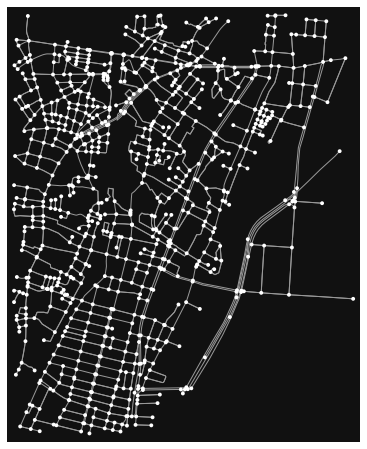

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
# next, lets plot the map to see
G = ox.graph_from_bbox(mr['north'], mr['south'], mr['east'], mr['west'], network_type='drive')
ox.plot_graph(G)

## generate route using OSMNX

In [5]:
# extract key points from start to destination
node_list = []
for key in G.nodes(data=False):
    node_list.append(key)

In [10]:
# node_list stores the ID of all places
# node_list

In [7]:
# random shuffle the IDs
node_list_perm = np.random.permutation(node_list)

In [8]:
# specify detailed info
car_n = 10
num_route = 3
N = car_n*num_route

start_list = node_list_perm[0:car_n]

In [9]:
# prepare destinations
import networkx as nx

n = 0
end_list = []

while len(end_list) < car_n:
    k = len(end_list)
    cand = node_list_perm[car_n+k+n]
    check = nx.has_path(G,start_list[k],cand)
    if check == 1:
    end_list.append(cand)
    else:
    n = n + 1

In [12]:
# prepare route considering the distance
def penalty(G,route,pen):
    for k in range(len(route)-1):
        i = route[k]
        j = route[k+1]
        G[i][j][0]['length'] += pen
    return G

In [13]:
# generate three choices of routes

route_list = []
for k in range(car_n):
    start_key = start_list[k]
    end_key = end_list[k]
    shortest_route1 = nx.shortest_path(G, start_key, end_key, 'length')
    route_list.append(shortest_route1) 
    G = penalty(G,shortest_route1,200)
    
    shortest_route2 = nx.shortest_path(G, start_key, end_key, 'length')
    route_list.append(shortest_route2) 
    G = penalty(G,shortest_route2,200)

    shortest_route3 = nx.shortest_path(G, start_key, end_key, 'length')
    route_list.append(shortest_route3) 
    G = penalty(G,shortest_route3,200)
    
    #長くした距離を戻す
    G = penalty(G,shortest_route1,-200)
    G = penalty(G,shortest_route2,-200)
    G = penalty(G,shortest_route3,-200)

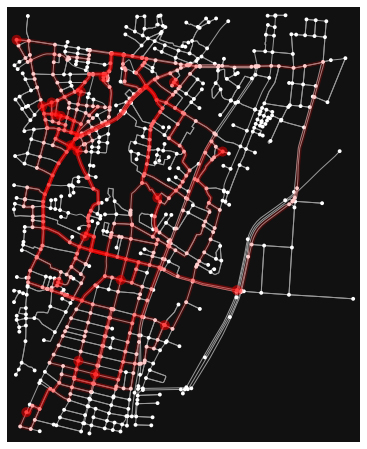

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [14]:
# plot the routes
ox.plot_graph_routes(G, route_list, route_alpha=0.2)

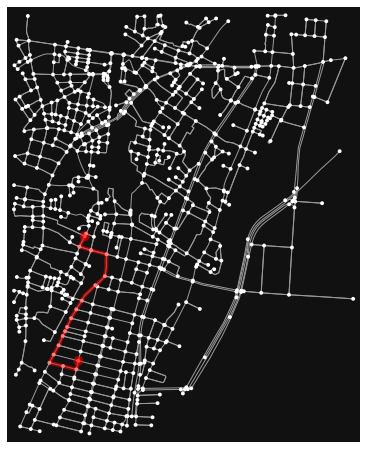

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [26]:
# only show the first route
ox.plot_graph_route(G, route_list[0])

## establish QUBO from routes
prepare $C_{e,m}$

In [17]:
edge_dict = {}
k = 0
for route in route_list:
    for l in range(len(route)-1):
        e = (route[l],route[l+1])
        if e not in edge_dict.keys():
            edge_dict[e] = k 
            k += 1

In [19]:
C = np.zeros(N*len(edge_dict)).reshape(len(edge_dict),N)
for i in range(car_n):
    for k in range(num_route):
        m = k+i*num_route
        p = route_list[m]
        for l in range(len(p)-1):
            e = edge_dict[(p[l],p[l+1])]
            C[e,m] = 1

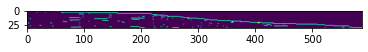

In [20]:
# visualization
plt.imshow(C.T)
plt.show()

lets compute the QUBO matrix<br>
firts item
\begin{equation}
\sum_e \left( \sum_m C_{e,m} x_{m} \right)^2 = \sum_e \left( \sum_m C_{e,m} x_{m} \right)\left( \sum_n C_{e,n} x_{n} \right) = \sum_{m,n} \sum_e C_{e,m} C_{e,n} x_{m} x_{n}
\end{equation}

In [21]:
Q1 = np.dot(C.T,C)

second item
\begin{equation}
\lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} -1 \right)^2 = \lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} -1 \right)\left( \sum_{l=1}^K x_{il} -1 \right)
\end{equation}

\begin{equation}
\lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} -1 \right)^2 = \lambda \sum_{i=1}^N \sum_{k=1}^K \sum_{l=1}^K x_{ik}  x_{il} -2 \lambda\sum_{i=1}^N\sum_{k=1}^K x_{ik}+ \lambda KN
\end{equation}

In [23]:
Q2 = np.zeros(N**2).reshape(N,N)

for i in range(car_n):
    for k in range(num_route):
        for l in range(num_route):
            m1 = k + i*num_route
            m2 = l + i*num_route
            Q2[m1,m2] = Q2[m1,m2] + 1.0
            if m1 == m2:
                Q2[m1,m2] = Q2[m1,m2] -2.0

In [27]:
lam = 60.0
Q = Q1 + lam*Q2

Qdict = {}
for m in range(N):
    for n in range(N):
        if Q[m,n] != 0.0:
            Qdict[m,n] = Q[m,n]

## QA

In [33]:
from openjij import SQASampler
sim_sampler = SQASampler()
Nsample = 10

sampleset = sim_sampler.sample_qubo(Qdict, num_reads = Nsample)
print(sampleset.record)
print(sampleset.first)

[([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0], -284., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], -308., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], -310., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], -307., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], -310., 1)
 ([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], -297., 1)
 ([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], -267., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], -310., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], -309., 1)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0

In [34]:
# picks the best choice
dw_answer = sampleset.record[0][0]

dw_answer_routes = []
answer_list = np.where(dw_answer == 1)[0]
for m in answer_list:
    print(m)
    dw_answer_routes.append(route_list[m])

2
7
10
12
17
20
23
24
27


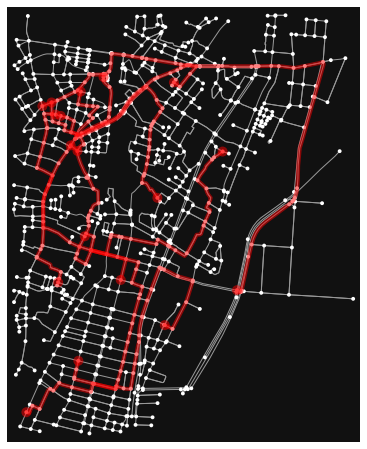

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [35]:
# plot the best choice
ox.plot_graph_routes(G, dw_answer_routes, route_alpha= 0.5)